## Section 1: Introduction

### Title of project: Churn Prediction of telco subscribers

Explore telco data to determine customer retention, based on details such as customer characteristics, spending, etc.

### Data source

The data is a sample dataset obtained online from IBM watsons analytics.

https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

### Expected output

With the model developed, to classify new customers into churn or non-churn based on their details.

Telco will then be able to target 'at risk' customers to try to retain them with various marketing strategies etc.

## Section 2: Data pipeline


### Tasks

The usual data science pipeline will be deployed. 
 
1. Data obtained (online source)
2. Data Engineering
3. Train Model
 * Neural Network (Try once before feature engineering)
4. Feature engineering
 * Select Kbest
5. Train Model(s)
 * Neural Network
 * SVC
 * KNN
 * Decision Tree
6. Compare models and select best model
7. Conclusion

## Section 3: Data Engineering

* Data Cleaning
* Data Exploration
* Data Encoding

First, let's set us up with the necessary libraries.

In [1]:
# Loading necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score,r2_score

from sklearn.tree import DecisionTreeClassifier
import pickle
import numpy as np

%matplotlib inline

In [2]:
# Load data
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.info()

# after a quick check of the dataset using df.info(), it looks like there's quite a number of columns with binary features
# i.e. type of column is object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
# CHeck for imbalanced data
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [5]:
# Let's set our target and feature columns
target='Churn'
features=df.columns[df.columns != target]

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Encoding

Inspect for columns to encode

In [7]:

for f in features:
    if (df[f].dtypes == 'object'):
        print('feature: ',f,'/ unique values: ',df[f].unique(),'/ length: ',len(df[f].unique()))

# It looks pretty alright at this point. For customerID, likely we can drop it as a feature since it has little bearing on Churn.
# For TotalCharges, it looks like it should be a numerical column instead.

feature:  customerID / unique values:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] / length:  7043
feature:  gender / unique values:  ['Female' 'Male'] / length:  2
feature:  Partner / unique values:  ['Yes' 'No'] / length:  2
feature:  Dependents / unique values:  ['No' 'Yes'] / length:  2
feature:  PhoneService / unique values:  ['No' 'Yes'] / length:  2
feature:  MultipleLines / unique values:  ['No phone service' 'No' 'Yes'] / length:  3
feature:  InternetService / unique values:  ['DSL' 'Fiber optic' 'No'] / length:  3
feature:  OnlineSecurity / unique values:  ['No' 'Yes' 'No internet service'] / length:  3
feature:  OnlineBackup / unique values:  ['Yes' 'No' 'No internet service'] / length:  3
feature:  DeviceProtection / unique values:  ['No' 'Yes' 'No internet service'] / length:  3
feature:  TechSupport / unique values:  ['No' 'Yes' 'No internet service'] / length:  3
feature:  StreamingTV / unique values:  ['No' 'Yes' 'No internet ser

In [8]:
# Convert the column 'TotalCharges' to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

In [9]:
df.info()
# running df.info() again and we can see that there are null values in the column now.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

In [10]:
# Check out the rows with null values in the TotalCharges column
df[df['TotalCharges'].isna()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
# There are 11 rows with missing values in Total Charges column
# Rather than deleting all the rows which will cause us to lose data, we can fill it with the mean value
# since it is not ordered data, no point using fill forward or fill backward.

# Let's fill in the null values with mean. Using the below format is my personal preference as it
# gives us space to add on to the dictionary if there are other examples in future where there's more columns with null values

values = {'TotalCharges': df['TotalCharges'].mean()}
df.fillna(value=values,inplace=True)


In [12]:
# check that there's no more missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

In [13]:
features=features.drop('customerID')

In [14]:
# store encoders in a dictionary so that we can refer to them easily for using / saving / loading
encoders_features = {}
from sklearn.preprocessing import OneHotEncoder

for f in features:
    if (df[f].dtypes == 'object'):
        if (len(df[f].unique())<=2):
            encoder = LabelEncoder()
            encoder.fit(df[f])        
            df[f] = encoder.transform(df[f])
            encoders_features[f] = encoder
        else:
            encoder = OneHotEncoder(sparse=False)
            encoder.fit(df[[f]])        
            encoded=pd.DataFrame(encoder.transform(df[[f]]))
            encoded.columns= [f+'_'+str(int(i)) for i in range(len(df[f].unique()))]
            df = pd.concat([df, encoded], axis=1)
            df.drop(columns=[f],inplace=True)
            encoders_features[f] = encoder


In [15]:
# inspect the encoded classes
for k, v in encoders_features.items():
    if type(v)==LabelEncoder:
        print(k, df[k].unique(), v.classes_)
    elif type(v)==OneHotEncoder:
        print(k, v.categories_)
    else:
        print(k)

gender [0 1] ['Female' 'Male']
Partner [1 0] ['No' 'Yes']
Dependents [0 1] ['No' 'Yes']
PhoneService [0 1] ['No' 'Yes']
MultipleLines [array(['No', 'No phone service', 'Yes'], dtype=object)]
InternetService [array(['DSL', 'Fiber optic', 'No'], dtype=object)]
OnlineSecurity [array(['No', 'No internet service', 'Yes'], dtype=object)]
OnlineBackup [array(['No', 'No internet service', 'Yes'], dtype=object)]
DeviceProtection [array(['No', 'No internet service', 'Yes'], dtype=object)]
TechSupport [array(['No', 'No internet service', 'Yes'], dtype=object)]
StreamingTV [array(['No', 'No internet service', 'Yes'], dtype=object)]
StreamingMovies [array(['No', 'No internet service', 'Yes'], dtype=object)]
Contract [array(['Month-to-month', 'One year', 'Two year'], dtype=object)]
PaperlessBilling [1 0] ['No' 'Yes']
PaymentMethod [array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object)]


In [16]:
for f in df.columns:
    if (df[f].dtypes == 'object'):
        print('feature: ',f,'/ unique values: ',df[f].unique(),'/ length: ',len(df[f].unique()))

feature:  customerID / unique values:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] / length:  7043
feature:  Churn / unique values:  ['No' 'Yes'] / length:  2


### PCA for visualisation

In this section, we will plot out the PCA for the data.

In [17]:
PCA_df=df.drop(['customerID'],axis=1)

In [18]:
# encode Churn in the PCA
encoder_pca = LabelEncoder()
PCA_df['Churn']=encoder_pca.fit_transform(PCA_df['Churn'])


In [19]:
PCA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
gender                7043 non-null int32
SeniorCitizen         7043 non-null int64
Partner               7043 non-null int32
Dependents            7043 non-null int32
tenure                7043 non-null int64
PhoneService          7043 non-null int32
PaperlessBilling      7043 non-null int32
MonthlyCharges        7043 non-null float64
TotalCharges          7043 non-null float64
Churn                 7043 non-null int32
MultipleLines_0       7043 non-null float64
MultipleLines_1       7043 non-null float64
MultipleLines_2       7043 non-null float64
InternetService_0     7043 non-null float64
InternetService_1     7043 non-null float64
InternetService_2     7043 non-null float64
OnlineSecurity_0      7043 non-null float64
OnlineSecurity_1      7043 non-null float64
OnlineSecurity_2      7043 non-null float64
OnlineBackup_0        7043 non-null float64
OnlineBackup_1        7043 no

In [20]:
scaler = StandardScaler()
PCA_scaled = scaler.fit_transform(PCA_df)

C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
y=PCA_df[target]

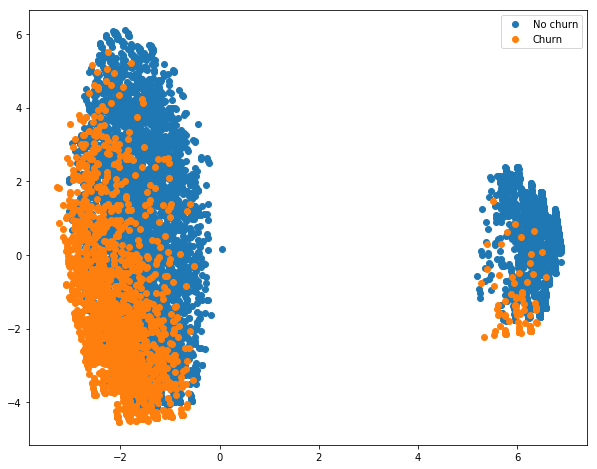

In [22]:

pca_2d = PCA(n_components=2)
PCA_2d = pca_2d.fit_transform(PCA_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(PCA_2d[y==0, 0], PCA_2d[y==0, 1], label='No churn') # filter for y==0
ax.scatter(PCA_2d[y==1, 0], PCA_2d[y==1, 1], label='Churn') # filter for y==1
ax.legend()

Using PCA to guide the model:

* if there is an overlap of the data points, try increasing layers of the network
* if there is a distinct boundary but the model is not doing well, try increasing the number of neurons in the hidden layer.


In [23]:
# Setting up features columns

exclude=['customerID', target]
features_list=[f for f in df.columns if f not in exclude]

X=df[features_list]
y=df[target]

In [24]:

# encode y

encoder = LabelEncoder()
encoder.fit(y)
y=encoder.transform(y)

# store encoder for target in a dictionary as well
encoders_target = {}
encoders_target[target] = encoder


In [25]:
# Churn
# 0 for No
# 1 for Yes (target)

### Neural Network before feature engineering:

* Try out using MLP (Multi-layer-perceptron) before Kbest and we can compare the effects later

In [26]:
import keras

Using TensorFlow backend.


In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [28]:
from keras.models import Sequential
from keras.layers import Dense

In [29]:
# try a model with one hidden layer and number of hidden units as average of input and output neurons

model_nn_all = Sequential()
model_nn_all.add(Dense(20, activation='relu', input_dim=40))
model_nn_all.add(Dense(20, activation='relu'))
model_nn_all.add(Dense(20, activation='relu'))
model_nn_all.add(Dense(output_dim=1, activation='sigmoid'))

C:\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  import sys


In [30]:
model_nn_all.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model_nn_all.fit(X_train,y_train,batch_size=10,nb_epoch=50,validation_split=0.1)

C:\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 4753 samples, validate on 529 samples
Epoch 1/50
4753/4753 [==============================] - 1s 276us/step - loss: 2.3075 - acc: 0.7105 - val_loss: 0.7656 - val_acc: 0.7070
Epoch 2/50
4753/4753 [==============================] - 1s 132us/step - loss: 1.2219 - acc: 0.7307 - val_loss: 0.5713 - val_acc: 0.7146
Epoch 3/50
4753/4753 [==============================] - 1s 130us/step - loss: 0.8573 - acc: 0.7404 - val_loss: 0.4706 - val_acc: 0.7675
Epoch 4/50
4753/4753 [==============================] - 1s 132us/step - loss: 0.7927 - acc: 0.7532 - val_loss: 0.4884 - val_acc: 0.7807
Epoch 5/50
4753/4753 [==============================] - 1s 127us/step - loss: 0.6099 - acc: 0.7618 - val_loss: 0.4681 - val_acc: 0.7750
Epoch 6/50
4753/4753 [==============================] - 1s 131us/step - loss: 0.6708 - acc: 0.7547 - val_loss: 0.5204 - val_acc: 0.7675
Epoch 7/50
4753/4753 [==============================] - 1s 132us/step - loss: 0.5814 - acc: 0.7692 - val_loss: 0.4467 - val_acc: 0.7807
E

In [31]:
trng_nn_all=history.history['loss']
val_nn_all=history.history['val_loss']

Text(0, 0.5, 'loss')

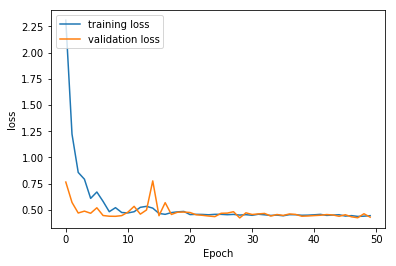

In [32]:
plt.plot(trng_nn_all)
plt.plot(val_nn_all)
plt.legend(['training loss','validation loss'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("loss")

## Can repeat again with 1 and 2 hidden layer

In [57]:
model_nn_all.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


## Section 4: Feature Engineering


* In this section, we will explore Feature Reduction using SelecKBest
* PCA plot in 2D

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [34]:

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

kbest = SelectKBest(f_classif)

params = {
    'kbest__k': list(range(3,41))
}

pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])


In [35]:
gs = GridSearchCV(pipeline, params, cv=3)

In [36]:
gs.fit(X,y)


C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001DDFF4097B8>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
print(gs.best_params_)
print(gs.best_score_)

{'kbest__k': 38}
0.8047706943064035


[Text(0, 0.5, 'mean test score'),
 Text(0.5, 0, 'k'),
 Text(0.5, 1.0, 'Elbow plot')]

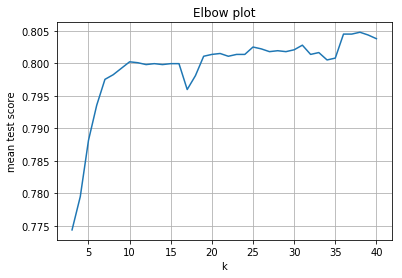

In [41]:
# plot the elbow curve

fig, ax = plt.subplots()

num_features = list(range(3, 41))
score_features = gs.cv_results_['mean_test_score']
ax.plot(num_features, score_features)
plt.grid(True)

ax.set(title='Elbow plot', xlabel='k', ylabel='mean test score')

Based on the plot, it looks like 10 features is a good choice.


In [42]:
# Let's use 10 features (ie k=10)

kbest = SelectKBest(f_classif, k=10)
X_kbest = kbest.fit_transform(X, y)

## Section 5: Model Engineering


* Regression methods
* Neural networks.



In [43]:
# split the data set into train and test set

X_train,X_test,y_train,y_test=train_test_split(X_kbest,y)

In [44]:
X_train.shape

(5282, 10)

In [45]:
# Check the shapes of the training and test sets

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)


X_train shape:  (5282, 10)
X_test shape:  (1761, 10)
y_train shape:  (5282,)
y_test shape:  (1761,)


Sections 5A - 5D will explore the use of different models and potential areas for tuning or improvement.
* Section 5A: Neural Network
* Section 5B: KNN
* Section 5C: SVC
* Section 5D: Decision Tree

### Section 5A: Neural Networks


* Using keras library to form the NN

In [46]:
import keras

In [47]:
from keras.models import Sequential
from keras.layers import Dense

In [48]:
# try a model with one hidden layer and number of hidden units as average of input and output neurons

model_nn = Sequential()
model_nn.add(Dense(5, activation='relu', input_dim=10))
model_nn.add(Dense(5, activation='relu'))
model_nn.add(Dense(5, activation='relu'))
model_nn.add(Dense(output_dim=1, activation='sigmoid'))

C:\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  import sys


In [49]:
model_nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [50]:
history=model_nn.fit(X_train,y_train,batch_size=10,nb_epoch=50,validation_split=0.1)

C:\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 4753 samples, validate on 529 samples
Epoch 1/50
4753/4753 [==============================] - 1s 277us/step - loss: 0.5070 - acc: 0.7393 - val_loss: 0.4725 - val_acc: 0.7996
Epoch 2/50
4753/4753 [==============================] - 1s 133us/step - loss: 0.4771 - acc: 0.7865 - val_loss: 0.4500 - val_acc: 0.8129
Epoch 3/50
4753/4753 [==============================] - 1s 130us/step - loss: 0.4561 - acc: 0.7894 - val_loss: 0.4214 - val_acc: 0.8185
Epoch 4/50
4753/4753 [==============================] - 1s 131us/step - loss: 0.4427 - acc: 0.7926 - val_loss: 0.4104 - val_acc: 0.8147
Epoch 5/50
4753/4753 [==============================] - 1s 135us/step - loss: 0.4335 - acc: 0.7944 - val_loss: 0.4062 - val_acc: 0.8166
Epoch 6/50
4753/4753 [==============================] - 1s 129us/step - loss: 0.4287 - acc: 0.7999 - val_loss: 0.3981 - val_acc: 0.8147
Epoch 7/50
4753/4753 [==============================] - 1s 140us/step - loss: 0.4279 - acc: 0.7949 - val_loss: 0.4047 - val_acc: 0.8204
E

In [51]:
trng_nn=history.history['loss']
val_nn=history.history['val_loss']

Text(0, 0.5, 'loss')

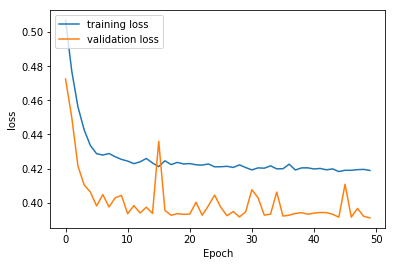

In [52]:
plt.plot(trng_nn)
plt.plot(val_nn)
plt.legend(['training loss','validation loss'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("loss")


In [53]:
model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


#### Predictions

In [58]:
pred_nn = model_nn.predict_classes(X_test)

In [59]:
# check the confusion matrix and precision/recall scores

# print classification report
print(classification_report(y_test, pred_nn))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1274
           1       0.65      0.49      0.56       487

   micro avg       0.79      0.79      0.79      1761
   macro avg       0.74      0.69      0.71      1761
weighted avg       0.77      0.79      0.78      1761



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

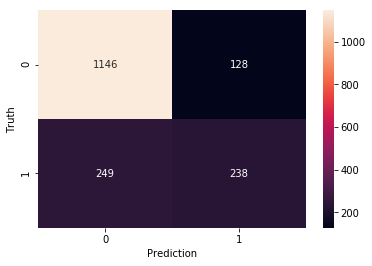

In [60]:
# print confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, pred_nn), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

## Section 5B: KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# k (number of neighbours) is tunable,
# so let's use GridSearchCV to find it

params = {
    'n_neighbors': np.arange(5, 80, 2)
}

# KNN can be sped up by setting n_jobs to run the distance
# computation in parallel
model_knn = KNeighborsClassifier(n_jobs=4)

gs_kn = GridSearchCV(model_knn, params, cv=10, return_train_score=True,n_jobs=4)
gs_kn.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37,
       39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71,
       73, 75, 77, 79])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [62]:
pd.DataFrame(gs_kn.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [63]:
neighbors=pd.DataFrame(gs_kn.cv_results_)['param_n_neighbors']
trng_kn=pd.DataFrame(gs_kn.cv_results_)['mean_train_score']
val_kn=pd.DataFrame(gs_kn.cv_results_)['mean_test_score']


Text(0, 0.5, 'accuracy')

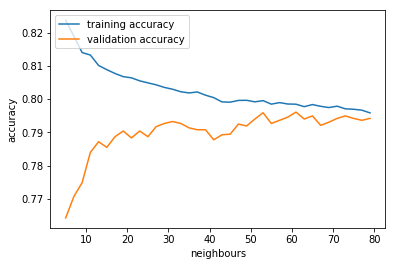

In [64]:
plt.plot(neighbors,trng_kn)
plt.plot(neighbors,val_kn)
plt.legend(['training accuracy','validation accuracy'], loc='upper left')
plt.xlabel("neighbours")
plt.ylabel("accuracy")


In [67]:
# print(random_search.best_params_)
# print(random_search.best_score_)

print(gs_kn.best_params_)
print(gs_kn.best_score_)

{'n_neighbors': 61}
0.7960999621355547


In [68]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=30)

#### Predictions

In [69]:
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)

#print(gs_kn.best_params_)
#print(gs_kn.best_score_)


In [70]:
# check the confusion matrix and precision/recall scores

# print classification report
print(classification_report(y_test, pred_knn))


              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1274
           1       0.64      0.46      0.54       487

   micro avg       0.78      0.78      0.78      1761
   macro avg       0.73      0.68      0.70      1761
weighted avg       0.77      0.78      0.77      1761



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

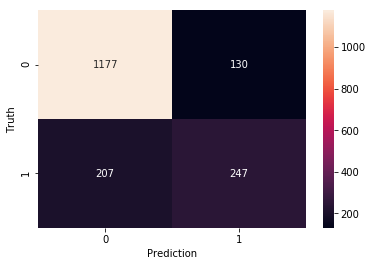

In [116]:
# print confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

### Section 5C: SVC

In [71]:
from sklearn.svm import SVC

In [72]:
# Train SVC
model_svc=SVC(random_state=42)
params={
    'C':[0.01,0.1,1.0],
    'gamma':[0.01,0.1,1.0]
}

In [73]:
gs_svc=GridSearchCV(model_svc,params,cv=10,return_train_score=True)
# scores_gs = cross_validate(gs_svc, X_train, y_train, cv=10,
#                        return_train_score=True, return_estimator=True)


In [74]:
# Warning: this part will take about 15 minutes to run

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(gs_svc, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Use all computer cores
                                                        n_jobs=4, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

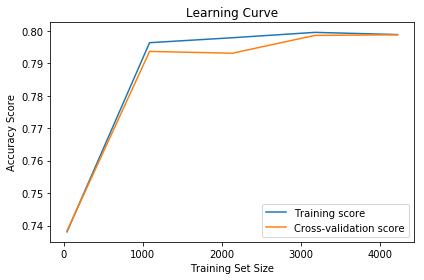

In [77]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# Draw bands
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [78]:
# This will take about 10 minutes to run

gs_svc.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1.0], 'gamma': [0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
print(gs_svc.best_params_)
print(gs_svc.best_score_)

{'C': 1.0, 'gamma': 0.01}
0.7968572510412723


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
# Can use the below code to extract the best model:

# ```model_svc=gs_svc.best_estimator_

# But let's insert the best params that we found into the code itself and use this model for predictions

model_svc=SVC(C=1.0,gamma=0.1)
model_svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Predictions

In [96]:
pred_svc = model_svc.predict(X_test)

In [97]:
# check the confusion matrix and precision/recall scores

# print classification report
print(classification_report(y_test, pred_svc))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1274
           1       0.66      0.49      0.56       487

   micro avg       0.79      0.79      0.79      1761
   macro avg       0.74      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

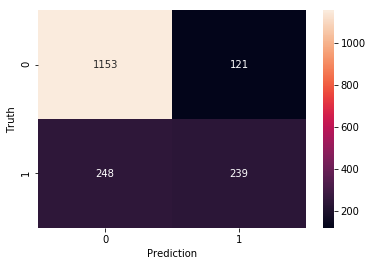

In [98]:
# print confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, pred_svc), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

### Section 5D: Using decision trees to visualise the important parameters

In [99]:
params = {
    'max_depth': np.arange(1,60,2)
}

model_dtc = DecisionTreeClassifier()

gs_dtc = GridSearchCV(model_dtc, params, cv=10, return_train_score=True)
gs_dtc.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [100]:
max_depth=pd.DataFrame(gs_dtc.cv_results_)['param_max_depth']
trng_dtc=pd.DataFrame(gs_dtc.cv_results_)['mean_train_score']
val_dtc=pd.DataFrame(gs_dtc.cv_results_)['mean_test_score']


Text(0, 0.5, 'accuracy')

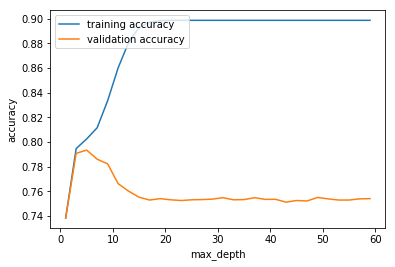

In [101]:
plt.plot(max_depth,trng_dtc)
plt.plot(max_depth,val_dtc)
plt.legend(['training accuracy','validation accuracy'], loc='upper left')
plt.xlabel("max_depth")
plt.ylabel("accuracy")


Based on the graph above, the most suitable depth is around 5. So we will use that for our model.

In [108]:
model_dtc = DecisionTreeClassifier(max_depth=5)

In [109]:
model_dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Predictions

In [110]:
pred_dtc = model_dtc.predict(X_test)

In [111]:
# check the confusion matrix and precision/recall scores

# print classification report
print(classification_report(y_test, pred_dtc))


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1274
           1       0.64      0.60      0.62       487

   micro avg       0.79      0.79      0.79      1761
   macro avg       0.74      0.73      0.74      1761
weighted avg       0.79      0.79      0.79      1761



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

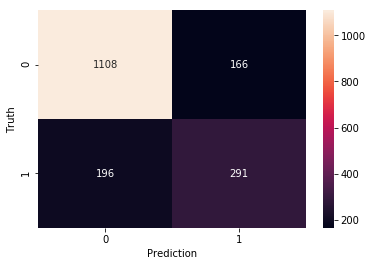

In [112]:
# print confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, pred_dtc), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

In [113]:
# Export decision tree visualisation to pdf file

from sklearn.tree import export_graphviz
import graphviz

filename = 'dtc_churnprediction.dot'
export_graphviz(model_dtc,
               out_file=filename,
               feature_names=X.columns[kbest.get_support()],
               filled=True,
               rounded=True)

source = graphviz.Source.from_file(filename)
source.render(view=True)

'dtc_churnprediction.dot.pdf'

### Trying out with RandomForestClassifier as well

Using max_depth = 5 which we obtained above

In [119]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=5)

In [131]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [132]:
pred_rf = model_rf.predict(X_test)

In [133]:
# check the confusion matrix and precision/recall scores

# print classification report
print(classification_report(y_test, pred_rf))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1274
           1       0.67      0.49      0.57       487

   micro avg       0.79      0.79      0.79      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

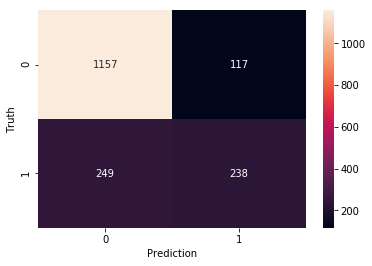

In [134]:
# print confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

## Section 6: Final model selection and evaluation metric


### Printing all the confusion matrix here for easy reference:


1. Neural Network

[Text(33.0, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Prediction'),
 Text(0.5, 1.0, 'Confusion Matrix for Neural Network')]

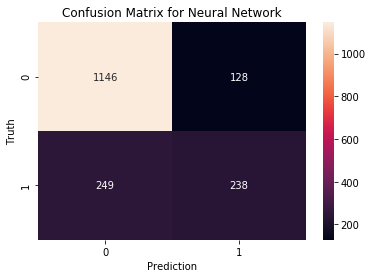

In [114]:
ax = sns.heatmap(confusion_matrix(y_test, pred_nn), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth', title= 'Confusion Matrix for Neural Network')

2. KNN

[Text(33.0, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Prediction'),
 Text(0.5, 1.0, 'Confusion Matrix for KNN')]

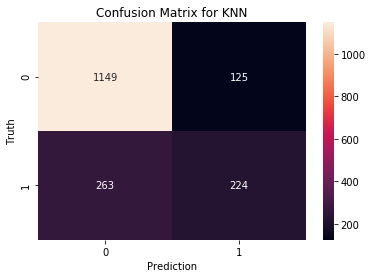

In [115]:
ax = sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth', title= 'Confusion Matrix for KNN')

3. SVC

[Text(33.0, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Prediction'),
 Text(0.5, 1.0, 'Confusion Matrix for SVC')]

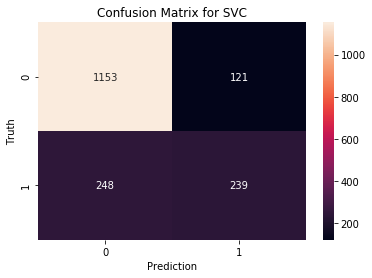

In [116]:
ax = sns.heatmap(confusion_matrix(y_test, pred_svc), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth', title= 'Confusion Matrix for SVC')

4. Decision Tree

[Text(33.0, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Prediction'),
 Text(0.5, 1.0, 'Confusion Matrix for Decision Tree Classifier')]

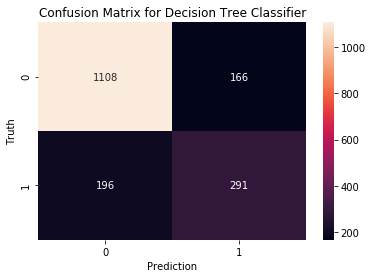

In [117]:
ax = sns.heatmap(confusion_matrix(y_test, pred_dtc), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth', title= 'Confusion Matrix for Decision Tree Classifier')

[Text(33.0, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Prediction'),
 Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')]

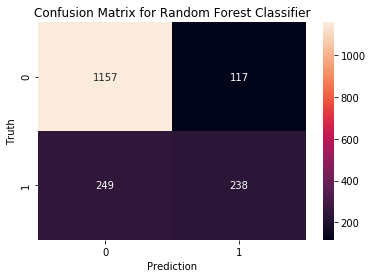

In [135]:
ax = sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth', title= 'Confusion Matrix for Random Forest Classifier')

## Section 7: Saving and deployment of models for use


In [ ]:
import pickle

# Inventory
# 1. final_model, which is our selected model
# 2. encoders_features, which we used for label encoding features
# 3. encoders_target, which we used for encoding target variable

inventory={'model':final_model,'encode_feature':encoders_features,'encode_target':encoders_target}

# opening file in 'write binary' mode
pickle.dump(inventory, open('inventory.pk', 'wb'))


In [ ]:
# example code to use when loading in another workbook

import pickle

# opening file in 'read binary' model
load_inventory = pickle.load(open('inventory.pk', 'rb'))


## Section 8: Observations and analysis

* Overall, the models all work similarly
* Work well to predict non-churn but not so good for churn

* Since our objective is to target the churn customers, we want to reduce the cases where customer is 1 [churn] but predicted as 0 [non-churn]


* So far, DTC works the “best” (lowest false negative)
* However as all the models seem pretty similar, further tuning could be done for the other models as well to achieve lesser false negative.